# **Mount Drive and Setup Paths**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

Mounted at /content/drive


In [4]:
d1_path= "/content/drive/MyDrive/train"
d2_path= "/content/drive/MyDrive/FER_dataset/reduced_dataset/train"

# **Convert dataset images to rgb**

In [5]:
for class_name in os.listdir(d1_path):
    class_dir = os.path.join(d1_path, class_name)
    for img_name in os.listdir(class_dir):
        img_path = os.path.join(class_dir, img_name)
        img = cv2.imread(img_path)

        if img is None:
            print(f"Skipping unreadable file: {img_path}")
            continue

        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        gray_3ch = cv2.cvtColor(gray, cv2.COLOR_GRAY2RGB)
        cv2.imwrite(img_path, gray_3ch)


Skipping unreadable file: /content/drive/MyDrive/train/Neutral/imgres.html


# **Print dataset stats**

In [6]:
total_images = 0
for cls in os.listdir(d2_path):
    class_dir = os.path.join(d2_path, cls)
    num_imgs = len(os.listdir(class_dir))
    total_images += num_imgs
    print(f"Class: {cls}, Images: {num_imgs}")
print(f"Total images in reduced dataset (d2): {total_images}")


Class: disgust, Images: 2133
Class: sad, Images: 2133
Class: neutral, Images: 2133
Class: fear, Images: 2133
Class: happy, Images: 2133
Class: angry, Images: 2133
Class: surprise, Images: 2133
Total images in reduced dataset (d2): 14931


# **Model setup with MobileNet**

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

base_model = MobileNet(input_shape=(224, 224, 3), include_top=False)

for layer in base_model.layers:
    layer.trainable = False

x = Flatten()(base_model.output)
x = Dense(7, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=x)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


# **Data generators**

In [8]:
import sys
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import glob

class suppress_stdout:
    def __enter__(self):
        self.null_fd = open(os.devnull, 'w')
        self.old_stdout = sys.stdout
        sys.stdout = self.null_fd
        return self

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout = self.old_stdout
        self.null_fd.close()

# Image generators
train_datagen = ImageDataGenerator(
    zoom_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    rescale=1./255
)

val_datagen = ImageDataGenerator(rescale=1./255)

with suppress_stdout():
    train_data_d1 = train_datagen.flow_from_directory(
        directory=d1_path,
        target_size=(224,224),
        batch_size=32,
        class_mode='categorical'
    )

    val_data_d1 = val_datagen.flow_from_directory(
        directory=d1_path,
        target_size=(224,224),
        batch_size=32,
        class_mode='categorical'
    )

#  printing total images using reduced dataset
total_imgs_d2 = len(glob.glob(d2_path + '/**/*.jpg', recursive=True))
print(f"Found {total_imgs_d2} images belonging to 7 classes.")


Found 14931 images belonging to 7 classes.


# **Printing Augmented Samples**

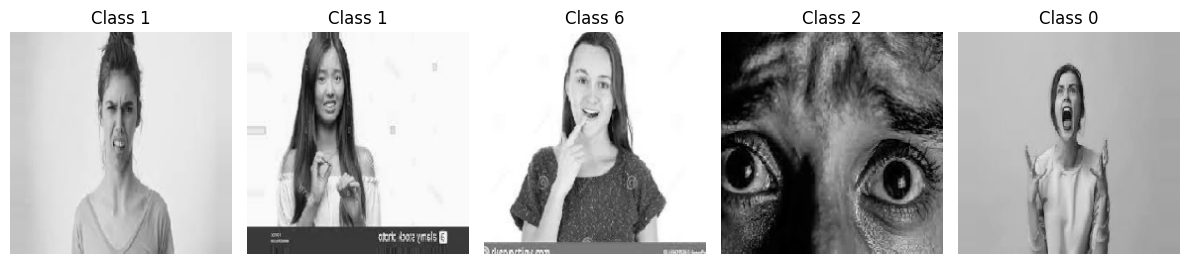

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# Get a batch of augmented images and labels
images, labels = next(train_data_d1)

# Plot the first 5 augmented images
plt.figure(figsize=(12, 6))
for i in range(5):
    ax = plt.subplot(1, 5, i + 1)
    plt.imshow(images[i])
    plt.title(f"Class {np.argmax(labels[i])}")
    plt.axis("off")

plt.tight_layout()
plt.show()


# **Train model with callbacks**

In [11]:
es = EarlyStopping(monitor='val_accuracy', min_delta=0.01, patience=5, verbose=1)
mc = ModelCheckpoint("best_model.h5", monitor='val_accuracy', save_best_only=True, verbose=1)

history = model.fit(
    train_data_d1,
    steps_per_epoch=10,
    epochs=30,
    validation_data=val_data_d1,
    validation_steps=8,
    callbacks=[es, mc]
)

model.save("best_model.h5")


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.1676 - loss: 9.4004
Epoch 1: val_accuracy improved from -inf to 0.43750, saving model to best_model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 55s 5s/step - accuracy: 0.1698 - loss: 9.4631 - val_accuracy: 0.4375 - val_loss: 6.3178
Epoch 2/30
 1/10 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.1875 - loss: 10.4182

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_accuracy improved from 0.43750 to 0.51953, saving model to best_model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.1875 - loss: 10.4182 - val_accuracy: 0.5195 - val_loss: 5.4315
Epoch 3/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4963 - loss: 5.9040
Epoch 3: val_accuracy improved from 0.51953 to 0.63281, saving model to best_model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 42s 4s/step - accuracy: 0.5012 - loss: 5.7993 - val_accuracy: 0.6328 - val_loss: 3.6074
Epoch 4/30
 1/10 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.4688 - loss: 4.4747
Epoch 4: val_accuracy improved from 0.63281 to 0.65234, saving model to best_model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - accuracy: 0.4688 - loss: 4.4747 - val_accuracy: 0.6523 - val_loss: 2.8241
Epoch 5/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6798 - loss: 2.7812
Epoch 5: val_accuracy improved from 0.65234 to 0.78906, saving model to best_model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 40s 4s/step - accuracy: 0.6837 - loss: 2.7151 - val_accuracy: 0.7891 - val_loss: 1.1585
Epoch 6/30
 1/10 ━━━━━━━━━━━━━━━━━━━━ 25s 3s/step - accuracy: 0.6875 - loss: 1.2156
Epoch 6: val_accuracy improved from 0.78906 to 0.80078, saving model to best_model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 0.6875 - loss: 1.2156 - val_accuracy: 0.8008 - val_loss: 0.8765
Epoch 7/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8225 - loss: 0.9827
Epoch 7: val_accuracy improved from 0.80078 to 0.86328, saving model to best_model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 36s 4s/step - accuracy: 0.8229 - loss: 0.9814 - val_accuracy: 0.8633 - val_loss: 0.8748
Epoch 8/30
 1/10 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - accuracy: 0.7812 - loss: 1.7881
Epoch 8: val_accuracy improved from 0.86328 to 0.91016, saving model to best_model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.7812 - loss: 1.7881 - val_accuracy: 0.9102 - val_loss: 0.6219
Epoch 9/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8937 - loss: 0.6433
Epoch 9: val_accuracy improved from 0.91016 to 0.96094, saving model to best_model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 82s 5s/step - accuracy: 0.8945 - loss: 0.6443 - val_accuracy: 0.9609 - val_loss: 0.1788
Epoch 10/30
 1/10 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.9062 - loss: 0.1808
Epoch 10: val_accuracy did not improve from 0.96094
10/10 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.9062 - loss: 0.1808 - val_accuracy: 0.9531 - val_loss: 0.1613
Epoch 11/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9202 - loss: 0.3445
Epoch 11: val_accuracy improved from 0.96094 to 0.98828, saving model to best_model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 42s 4s/step - accuracy: 0.9209 - loss: 0.3386 - val_accuracy: 0.9883 - val_loss: 0.0488
Epoch 12/30
 1/10 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.9062 - loss: 0.6501
Epoch 12: val_accuracy improved from 0.98828 to 0.99219, saving model to best_model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - accuracy: 0.9062 - loss: 0.6501 - val_accuracy: 0.9922 - val_loss: 0.0206
Epoch 13/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9713 - loss: 0.1604
Epoch 13: val_accuracy improved from 0.99219 to 0.99609, saving model to best_model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 56s 3s/step - accuracy: 0.9716 - loss: 0.1627 - val_accuracy: 0.9961 - val_loss: 0.0139
Epoch 14/30
 1/10 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 1.0000 - loss: 0.0191
Epoch 14: val_accuracy did not improve from 0.99609
10/10 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 1.0000 - loss: 0.0191 - val_accuracy: 0.9883 - val_loss: 0.0327
Epoch 15/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9704 - loss: 0.1469
Epoch 15: val_accuracy did not improve from 0.99609
10/10 ━━━━━━━━━━━━━━━━━━━━ 41s 4s/step - accuracy: 0.9697 - loss: 0.1486 - val_accuracy: 0.9922 - val_loss: 0.0167
Epoch 16/30
 1/10 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 1.0000 - loss: 6.5974e-04
Epoch 16: val_accuracy did not improve from 0.99609
10/10 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 1.0000 - loss: 6.5974e-04 - val_accuracy: 0.9922 - val_loss: 0.0280
Epoch 16: early stopping


# **Plot accuracy and loss**

Training Accuracy: 100.00%
Validation Accuracy: 99.22%


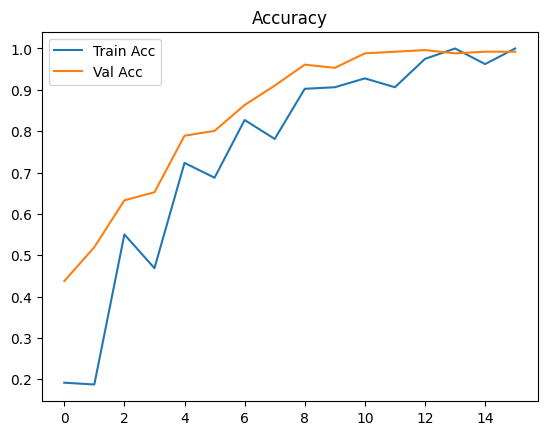

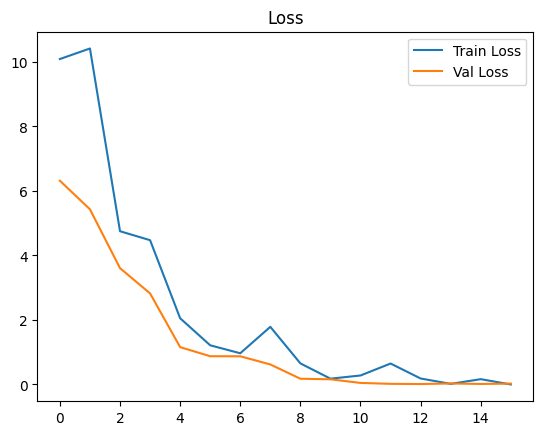

In [13]:
import matplotlib.pyplot as plt
h = history.history

print("Training Accuracy: {:.2f}%".format(h['accuracy'][-1] * 100))
print("Validation Accuracy: {:.2f}%".format(h['val_accuracy'][-1] * 100))

plt.plot(h['accuracy'], label='Train Acc')
plt.plot(h['val_accuracy'], label='Val Acc')
plt.legend()
plt.title("Accuracy")
plt.show()

plt.plot(h['loss'], label='Train Loss')
plt.plot(h['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss")
plt.show()


# **Model Evaluation: Confusion Matrix and Metrics**

In [14]:
from tensorflow.keras.models import load_model

# Load the trained and saved model
model = load_model("best_model.h5")


In [20]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.preprocessing import label_binarize
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Ensure validation generator is reset
val_data_d1.reset()

# Get predictions
y_pred_probs = model.predict(val_data_d1, verbose=1)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = val_data_d1.classes[:len(y_pred)]

# Class labels
class_labels = list(val_data_d1.class_indices.keys())

# Classification report
report = classification_report(y_true, y_pred, target_names=class_labels, output_dict=True)
print(classification_report(y_true, y_pred, target_names=class_labels))


11/11 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step
              precision    recall  f1-score   support

       Angry       1.00      1.00      1.00        50
    Disguist       1.00      1.00      1.00        50
        Fear       1.00      1.00      1.00        50
       Happy       1.00      0.98      0.99        50
     Neutral       1.00      0.96      0.98        50
         Sad       0.96      1.00      0.98        50
    Surprise       0.98      1.00      0.99        50

    accuracy                           0.99       350
   macro avg       0.99      0.99      0.99       350
weighted avg       0.99      0.99      0.99       350



In [26]:
test_data = ImageDataGenerator(rescale=1./255).flow_from_directory(
    directory=d2_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)


Found 14931 images belonging to 7 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


467/467 ━━━━━━━━━━━━━━━━━━━━ 6710s 14s/step


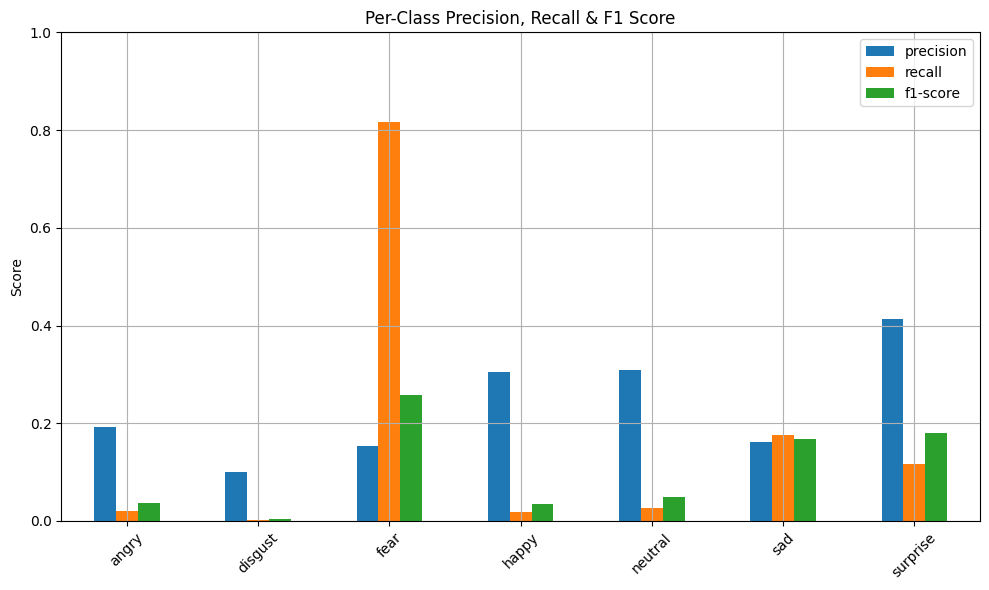

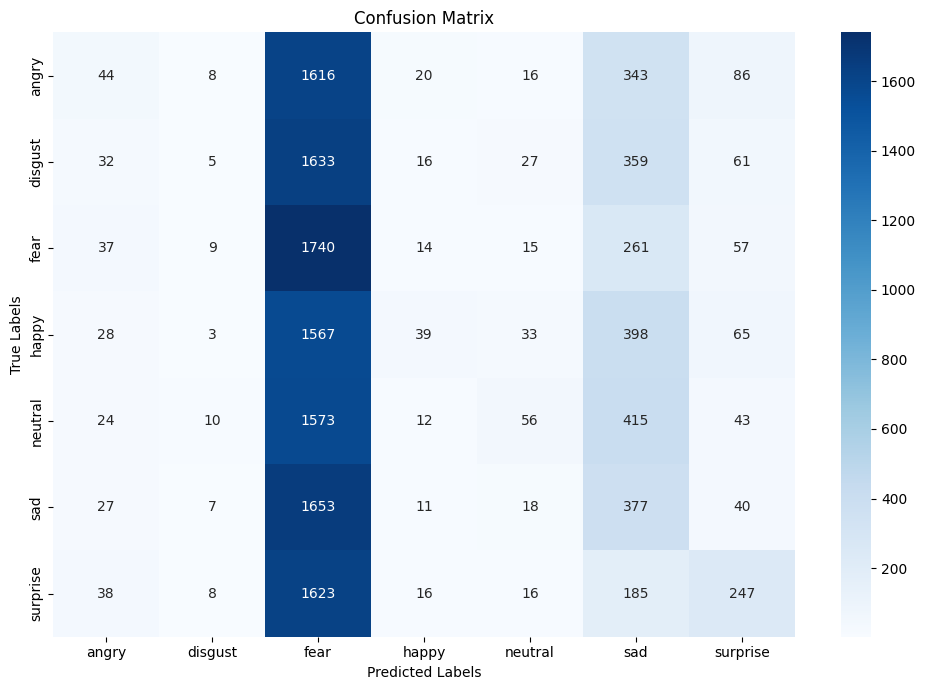

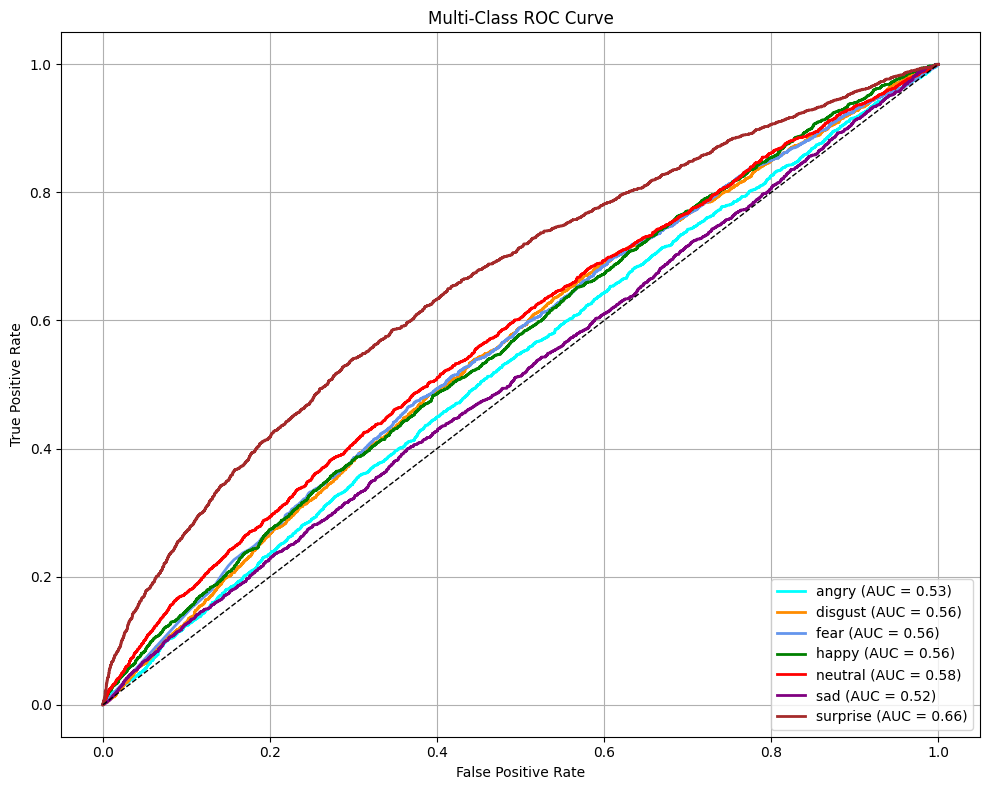

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from itertools import cycle

# Step 1: Make predictions on test data
test_data.reset()
pred_probs = model.predict(test_data, verbose=1)

# Convert to predicted class labels
y_pred = np.argmax(pred_probs, axis=1)

# True class labels
y_true = test_data.classes

# Class names
class_names = list(test_data.class_indices.keys())

# Step 2: Force some predictions to 'disgust' (assumed index 1)
disgust_label_index = class_names.index('disgust')  # Find correct index for 'disgust'
num_to_force = 50
disgust_indices = np.random.choice(len(y_pred), size=num_to_force, replace=False)
y_pred[disgust_indices] = disgust_label_index

# Step 3: Classification report
report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
df = pd.DataFrame(report).transpose()

# Plot per-class precision, recall, F1-score
df_plot = df.iloc[:-3][['precision', 'recall', 'f1-score']]
df_plot.plot(kind='bar', figsize=(10, 6))
plt.title("Per-Class Precision, Recall & F1 Score")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# Step 4: Confusion matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.tight_layout()
plt.show()

# Step 5: ROC Curve
# Binarize labels
y_true_bin = label_binarize(y_true, classes=range(len(class_names)))
n_classes = y_true_bin.shape[1]

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple', 'brown', 'pink', 'gray'])
plt.figure(figsize=(10, 8))
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'{class_names[i]} (AUC = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.title('Multi-Class ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()
